<a href="https://colab.research.google.com/github/olakursri/DSML/blob/master/Data_Extraction_Insights_SnowFlake_DocumentAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### EXTRACTING INSIGHTS FROM UNSTRUCTURED DATA
DOCUMENT AI Using SNOWFLAKE DATA Cloud

### OVERVIEW:
Document Extraction Model using Document AI by using this model to convert unstructured Inspection Reports into structured, easy-to-analyze rows and columns all within the Snowflake AI Data Cloud

### 1. Database, Warehouse, Role and Privileges

In [ ]:
-- assume the accountadmin role
USE ROLE accountadmin;

-- create the tb_doc_ai database
CREATE OR REPLACE DATABASE tb_doc_ai;

-- create the raw_doc schema
CREATE OR REPLACE SCHEMA tb_doc_ai.raw_doc;

-- create the doc_ai stage
CREATE OR REPLACE STAGE tb_doc_ai.raw_doc.doc_ai
    DIRECTORY = (ENABLE = TRUE)
    ENCRYPTION =  (TYPE = 'SNOWFLAKE_SSE');

-- create the inspection_reports stage
CREATE OR REPLACE STAGE tb_doc_ai.raw_doc.inspection_reports
    DIRECTORY = (ENABLE = TRUE)
    ENCRYPTION =  (TYPE = 'SNOWFLAKE_SSE');

-- create the doc_ai warehouse
CREATE OR REPLACE WAREHOUSE doc_ai
    WAREHOUSE_SIZE = 'small'
    WAREHOUSE_TYPE = 'standard'
    AUTO_SUSPEND = 60
    AUTO_RESUME = TRUE
    INITIALLY_SUSPENDED = TRUE
COMMENT = 'document ai warehouse';

-- create the tb_doc_ai role
CREATE OR REPLACE ROLE tb_doc_ai;

-- grant document ai privileges
GRANT DATABASE ROLE SNOWFLAKE.DOCUMENT_INTELLIGENCE_CREATOR TO ROLE tb_doc_ai;

-- grant doc_ai warehouse privileges
GRANT USAGE, OPERATE ON WAREHOUSE doc_ai TO ROLE tb_doc_ai;

-- grant tb_doc_ai database privileges
GRANT ALL ON DATABASE tb_doc_ai TO ROLE tb_doc_ai;
GRANT ALL ON SCHEMA tb_doc_ai.raw_doc TO ROLE tb_doc_ai;
GRANT CREATE STAGE ON SCHEMA tb_doc_ai.raw_doc TO ROLE tb_doc_ai;
GRANT CREATE SNOWFLAKE.ML.DOCUMENT_INTELLIGENCE ON SCHEMA tb_doc_ai.raw_doc TO ROLE tb_doc_ai;
GRANT ALL ON ALL STAGES IN SCHEMA tb_doc_ai.raw_doc TO ROLE tb_doc_ai;

-- set my_user_var variable to equal the logged-in user
SET my_user_var = (SELECT  '"' || CURRENT_USER() || '"' );

-- grant the logged in user the doc_ai_role
GRANT ROLE tb_doc_ai TO USER identifier($my_user_var);

### 2. Downloading and Unzipping our Inspection Reports

https://github.com/Snowflake-Labs/sfquickstarts/blob/master/site/sfguides/src/tasty_bytes_extracting_insights_with_docai/assets/inspection_reports_train.zip?_fsi=oeNmyumH

https://github.com/Snowflake-Labs/sfquickstarts/blob/master/site/sfguides/src/tasty_bytes_extracting_insights_with_docai/assets/inspection_reports_full.zip?_fsi=oeNmyumH

Data -> Databases and then search for TB_DOC_AI. From there navigate to the RAW_DOC schema and the INSPECTION_REPORTS stage.

Upload  unzipped Inspection Reports Full



### 3. Creating our Document AI Build

In [ ]:
Within the Snowsight interface please switch your role to TB_DOC_AI and, navigate to AI & ML -> Document AI. From there click the + Build button.

Within the New Build screen, enter the following:

Build Name: INSPECTION_REPORT_EXTRACTION
Choose Database: TB_DOC_AI
Choose Schema: RAW_DOC

After the build creation is successful, we will land in our Document AI Build Details window, where we can begin our document upload by clicking the Upload documents button.

Within the Upload documents screen drop or browse to the unzipped Training Inspection Reports from Step 1. From there click Upload.



Specifying our Values and Questions
Once the upload process is complete, please click Define value so we can begin to specify value names and questions we want to ask the model.

To begin defining our values to extract from our documents, click the Add value button in the right-hand window.

From here please enter the following set of Values and Questions one by one that are documented below. For each pair, please complete the following before clicking Add value to enter the next pair:

Did the Model extract the Value correctly?

If Yes - Click the check-box to indicate this value was extracted correctly.
If No - Delete the provided value and enter the correct value.
Value | Question

TRUCK_ID: What is the Truck Identifier?
DATE: What is the Date?
PIC_PRESENT: Was the Person in charge present (Y or N)?
FOOD_PROPER_TEMP: Was the Food received at the proper temperature (Y or N)?
VEHICLE_RUNS_WELL: Did the Vehicle run and was it in well maintained condition?

Reviewing our Test Documents
After completing our initial document review in the previous step, we will now review the models' initial extraction results for our remaining test documents.
After completing review of all documents, please navigate back to the Document AI UI by click the arrow next to Documents review

### 4. Training our Model

Using the Model accuracy tile, we will now train our model by clicking the Train model button. Within the Start training pop-up click Start Training which will take around 20 minutes.

For more on Document AI training time estimation please visit our Document AI documentation.
When training is complete, you will see Trained next to the model name indicating it is ready to be leveraged.

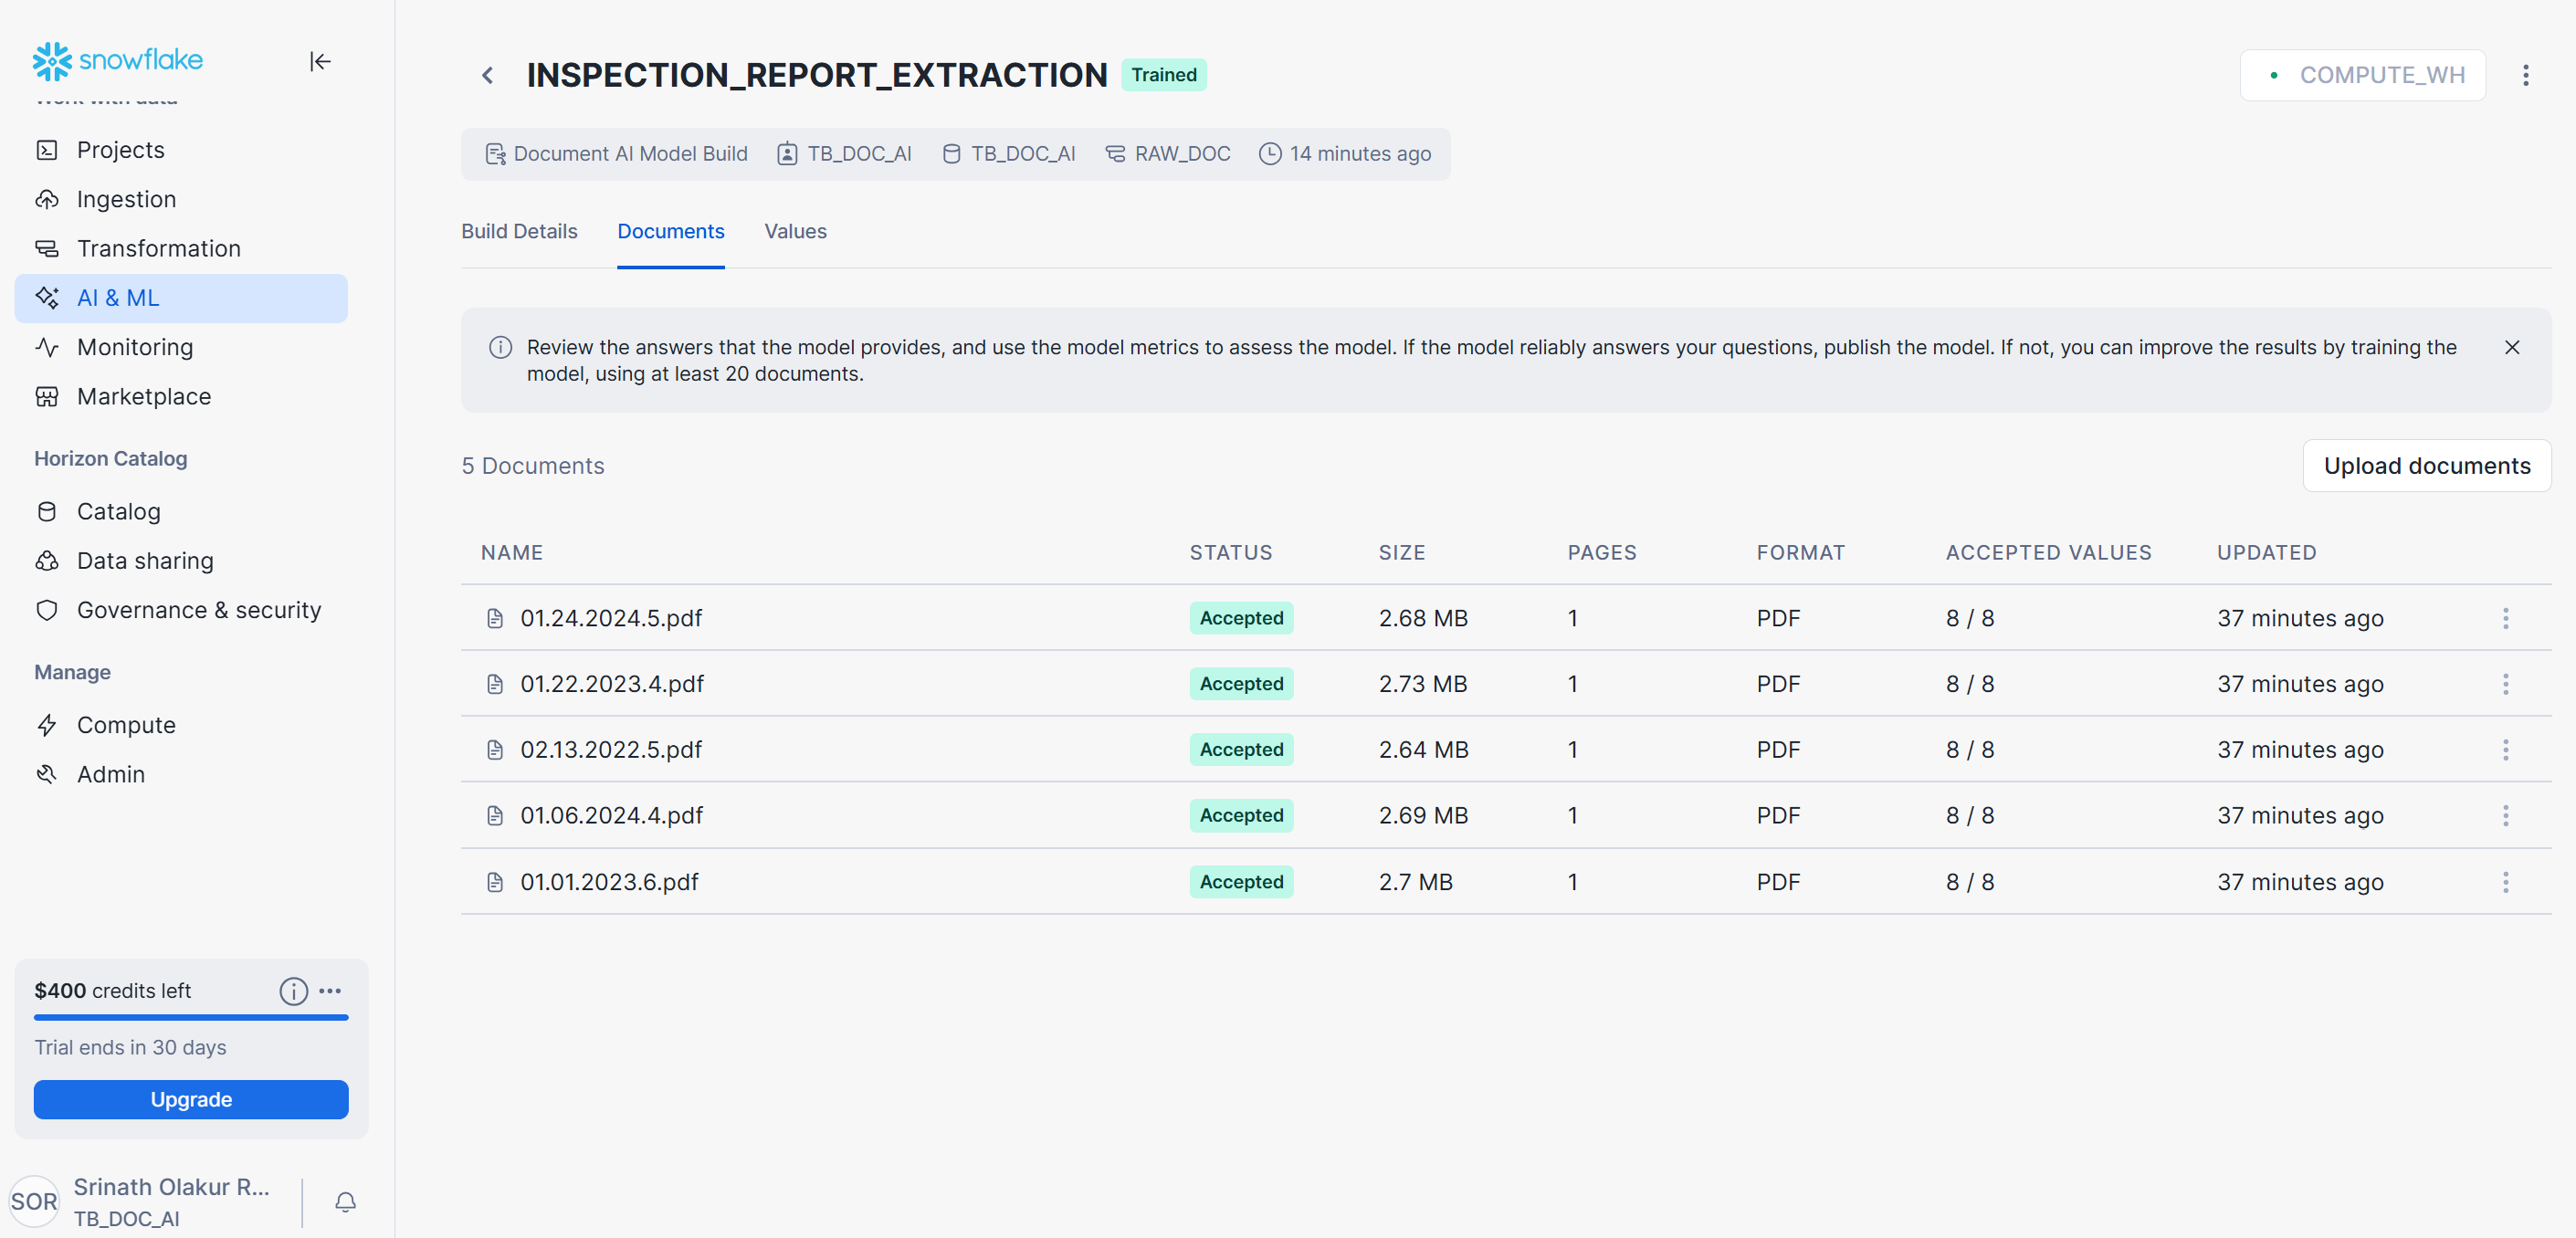

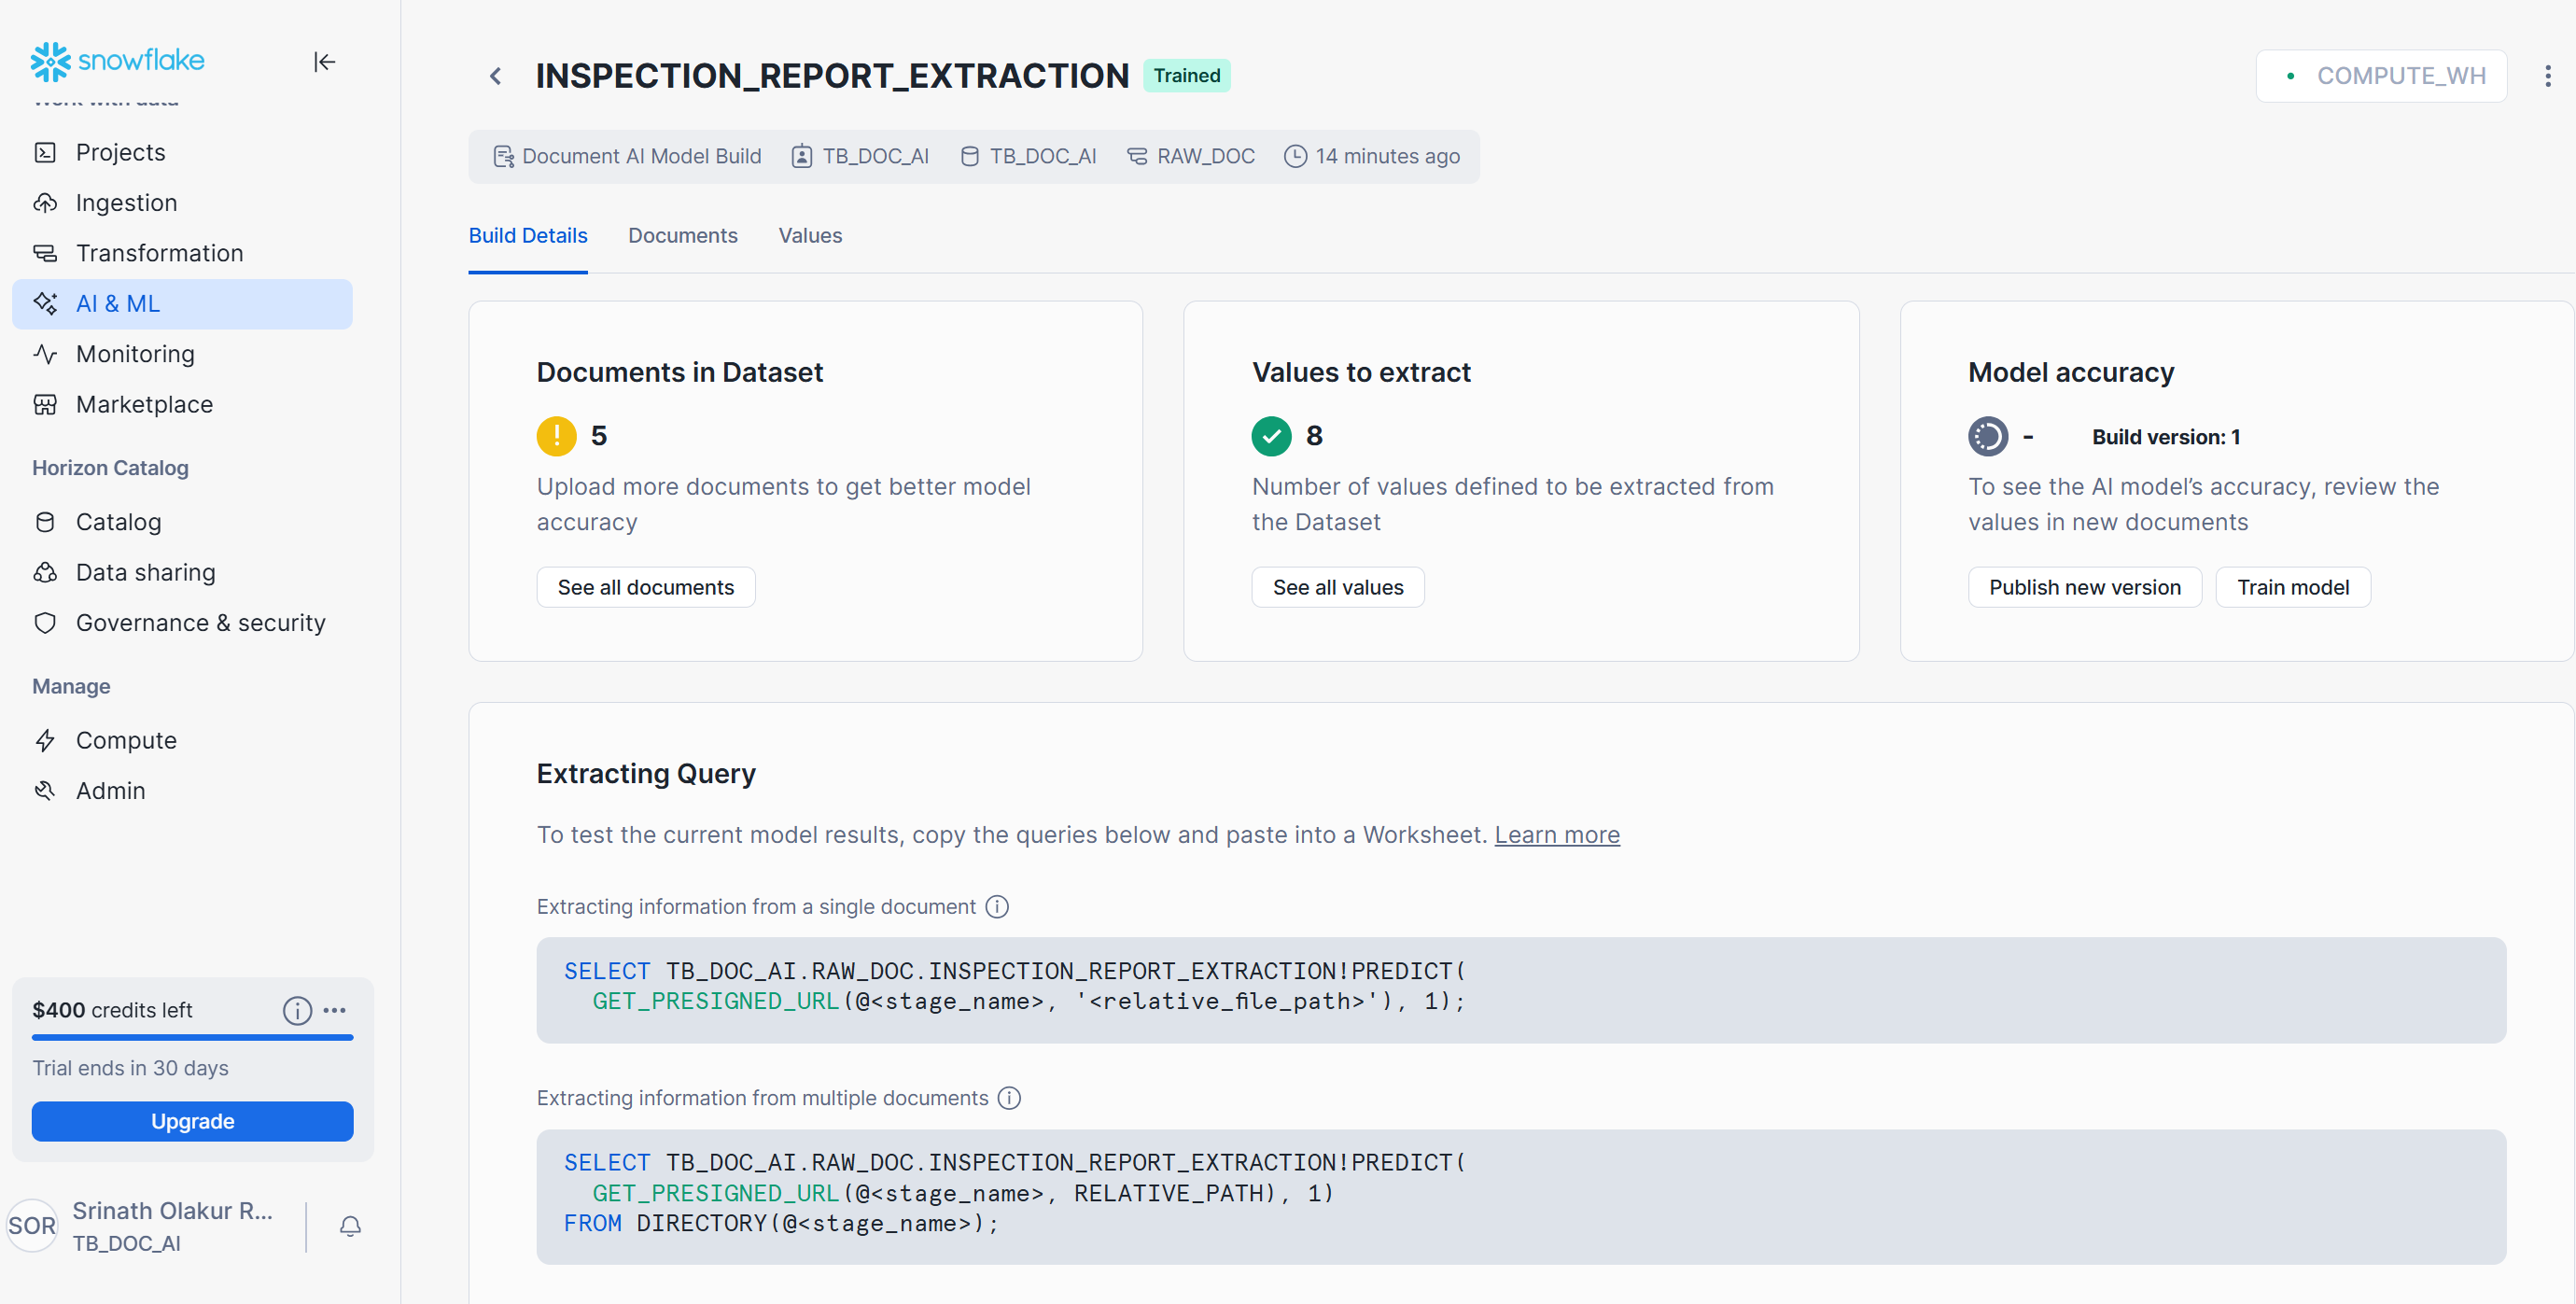

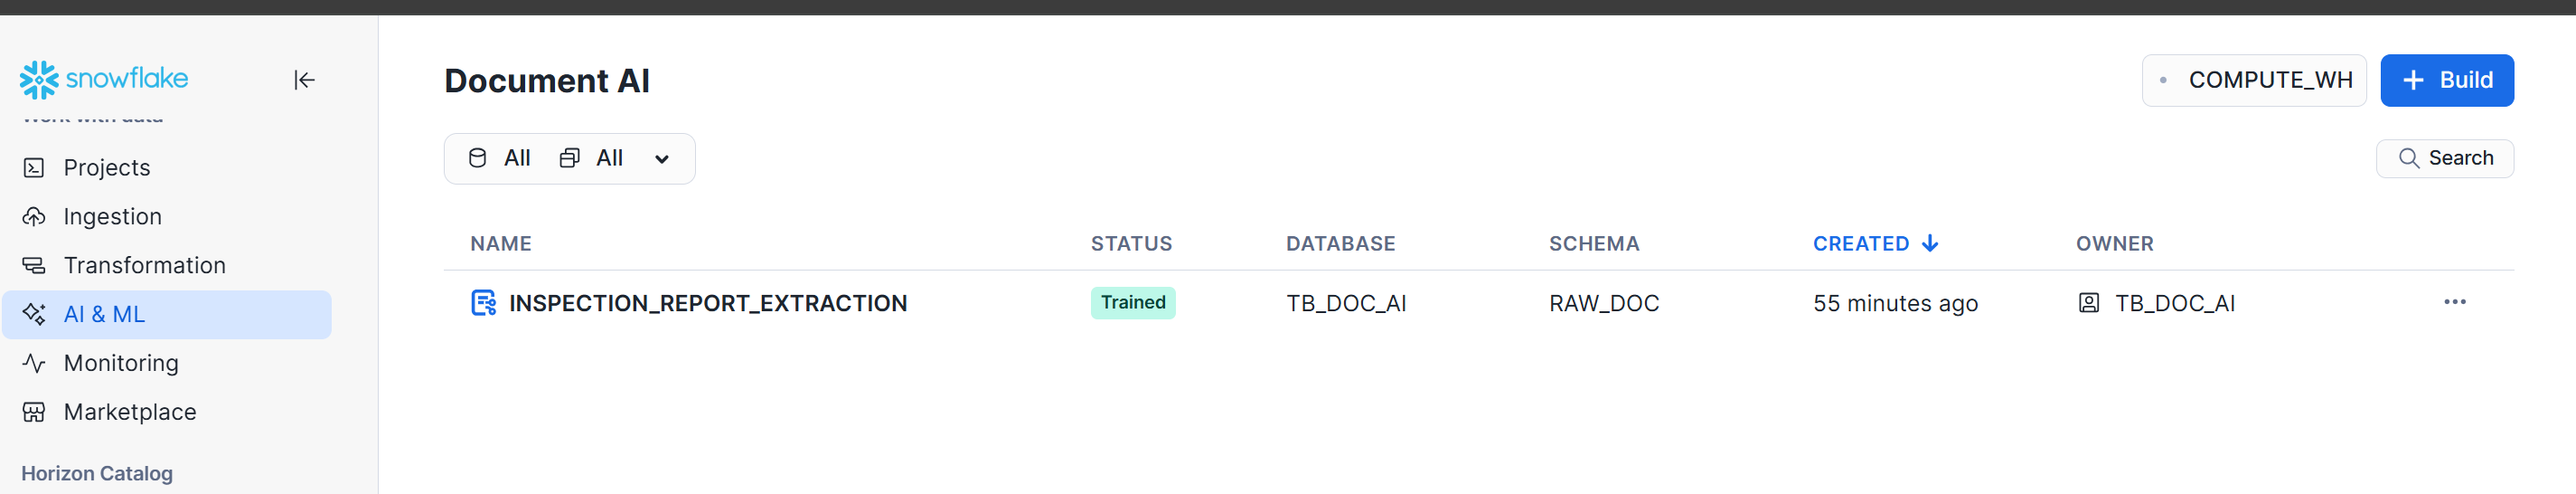

### 5 Using our Document AI Model against our Inspection Reports

In [ ]:
#Setting our Context
USE ROLE tb_doc_ai;
USE WAREHOUSE doc_ai;
USE DATABASE tb_doc_ai;
USE SCHEMA raw_doc;
#Listing our Staged Inspection Reports
LIST @inspection_reports;
# Extraction for a single Document
SELECT inspection_report_extraction!PREDICT(GET_PRESIGNED_URL(@inspection_reports, '02.13.2022.5.pdf'));


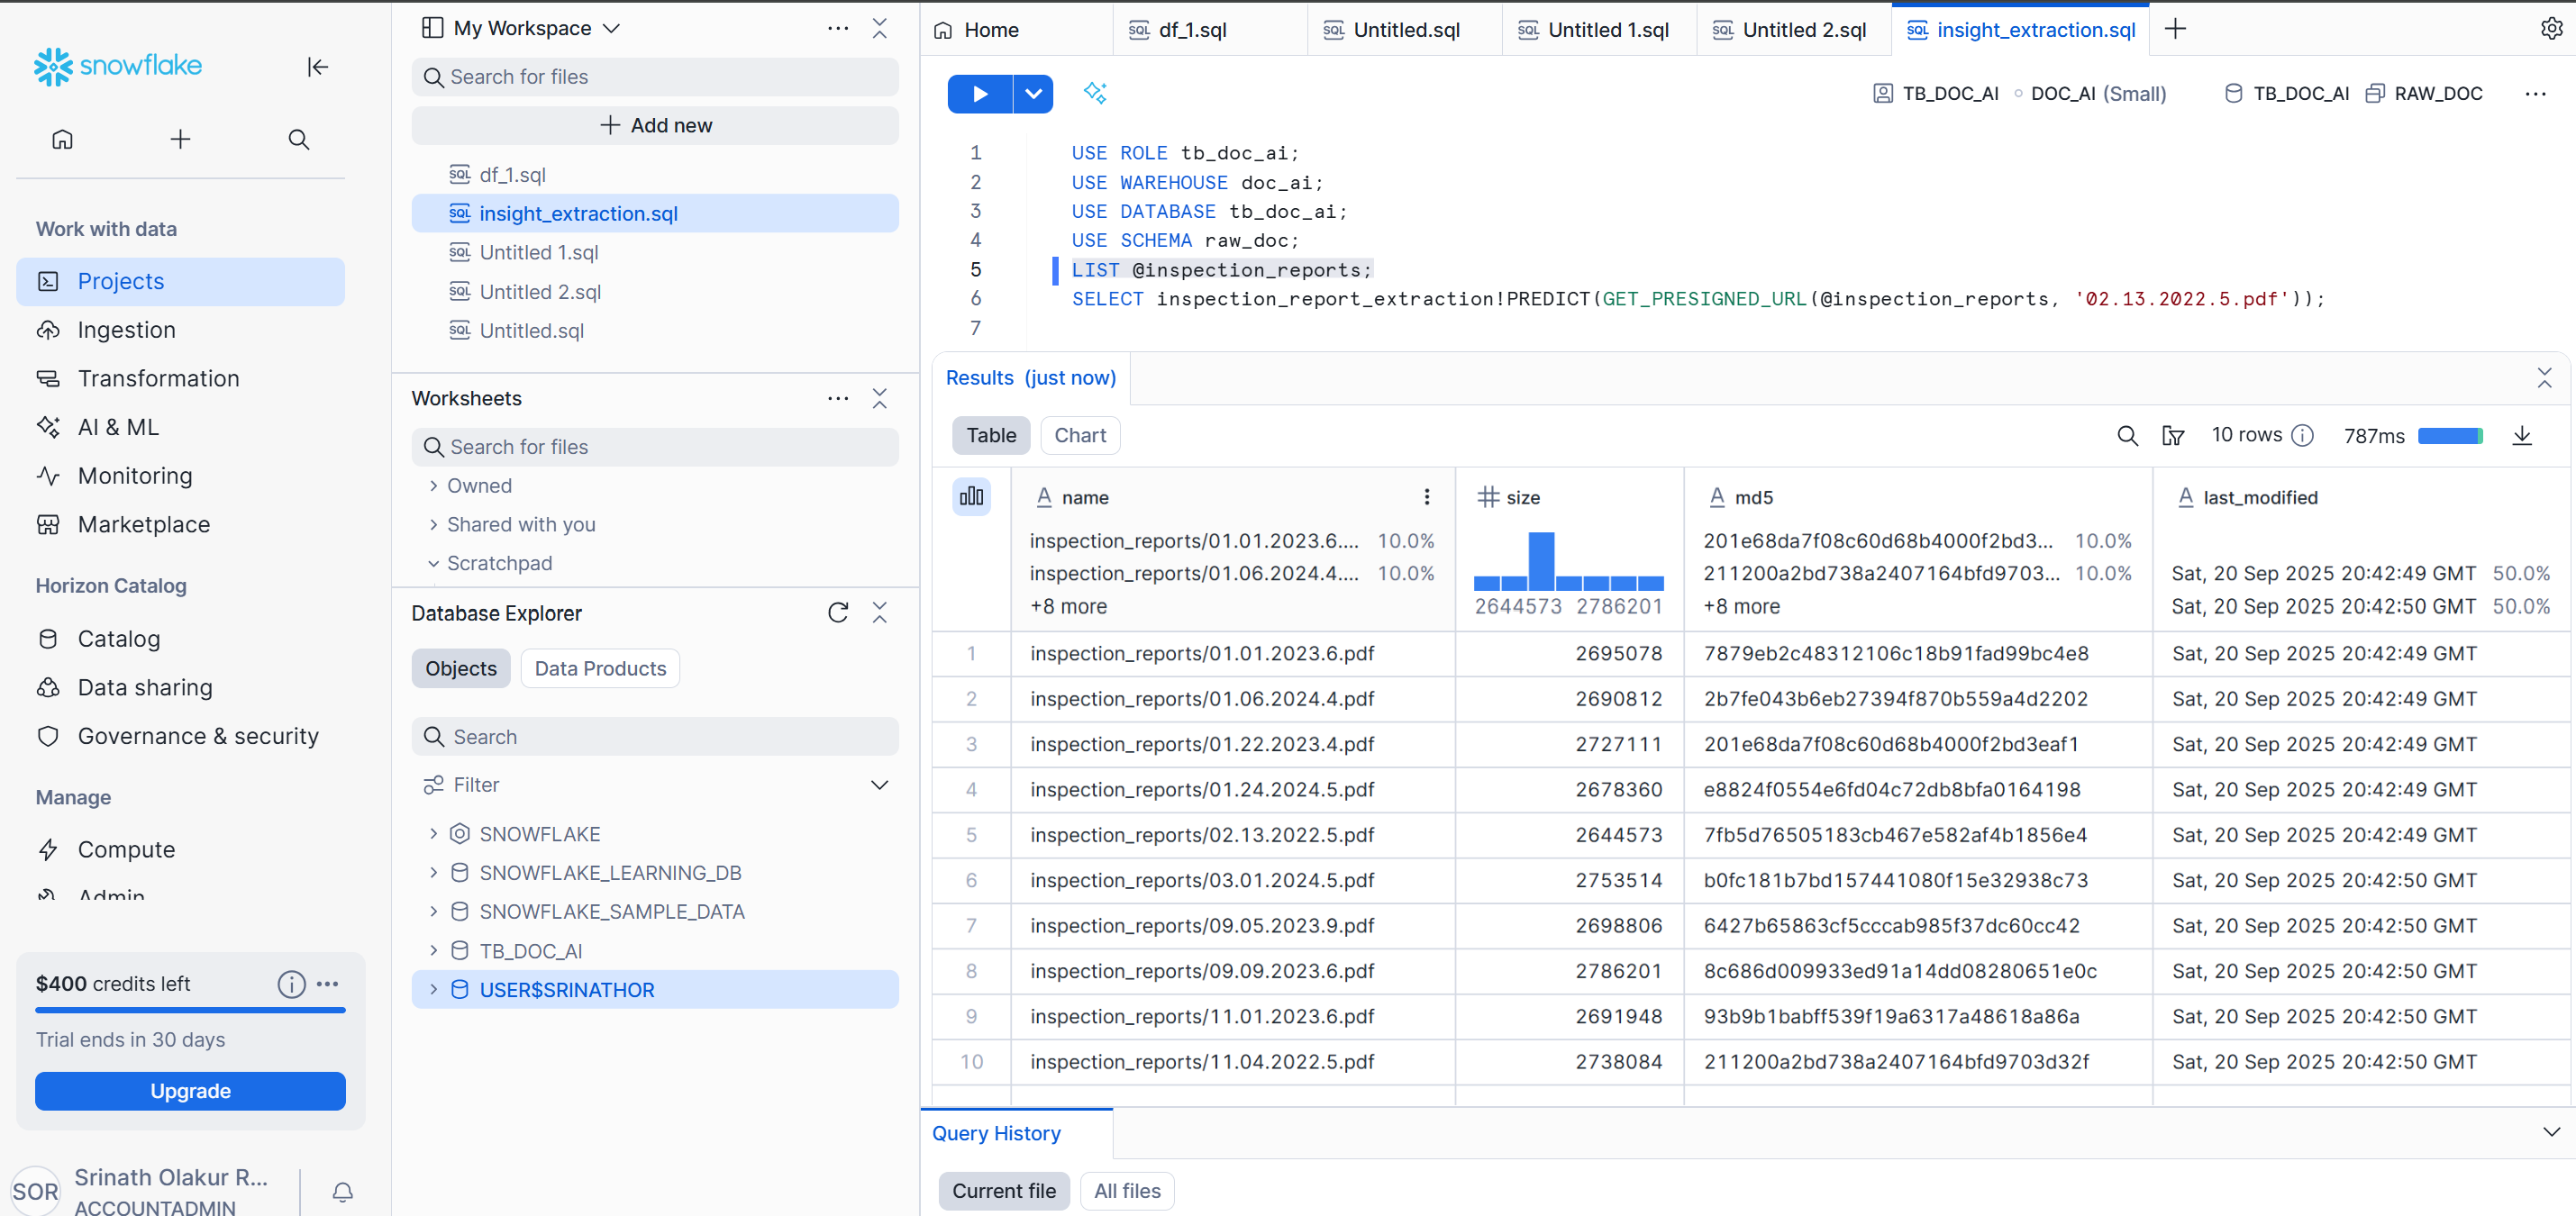

# Extraction for all Documents

In [ ]:
CREATE OR REPLACE TABLE ir_raw
COMMENT = '{"origin":"sf_sit-is", "name":"voc", "version":{"major":1, "minor":0}, "attributes":{"is_quickstart":1, "source":"sql", "vignette":"docai"}}'
AS
SELECT inspection_report_extraction!PREDICT(GET_PRESIGNED_URL(@inspection_reports, RELATIVE_PATH)) AS ir_object
FROM DIRECTORY(@inspection_reports);


SELECT * FROM ir_raw;

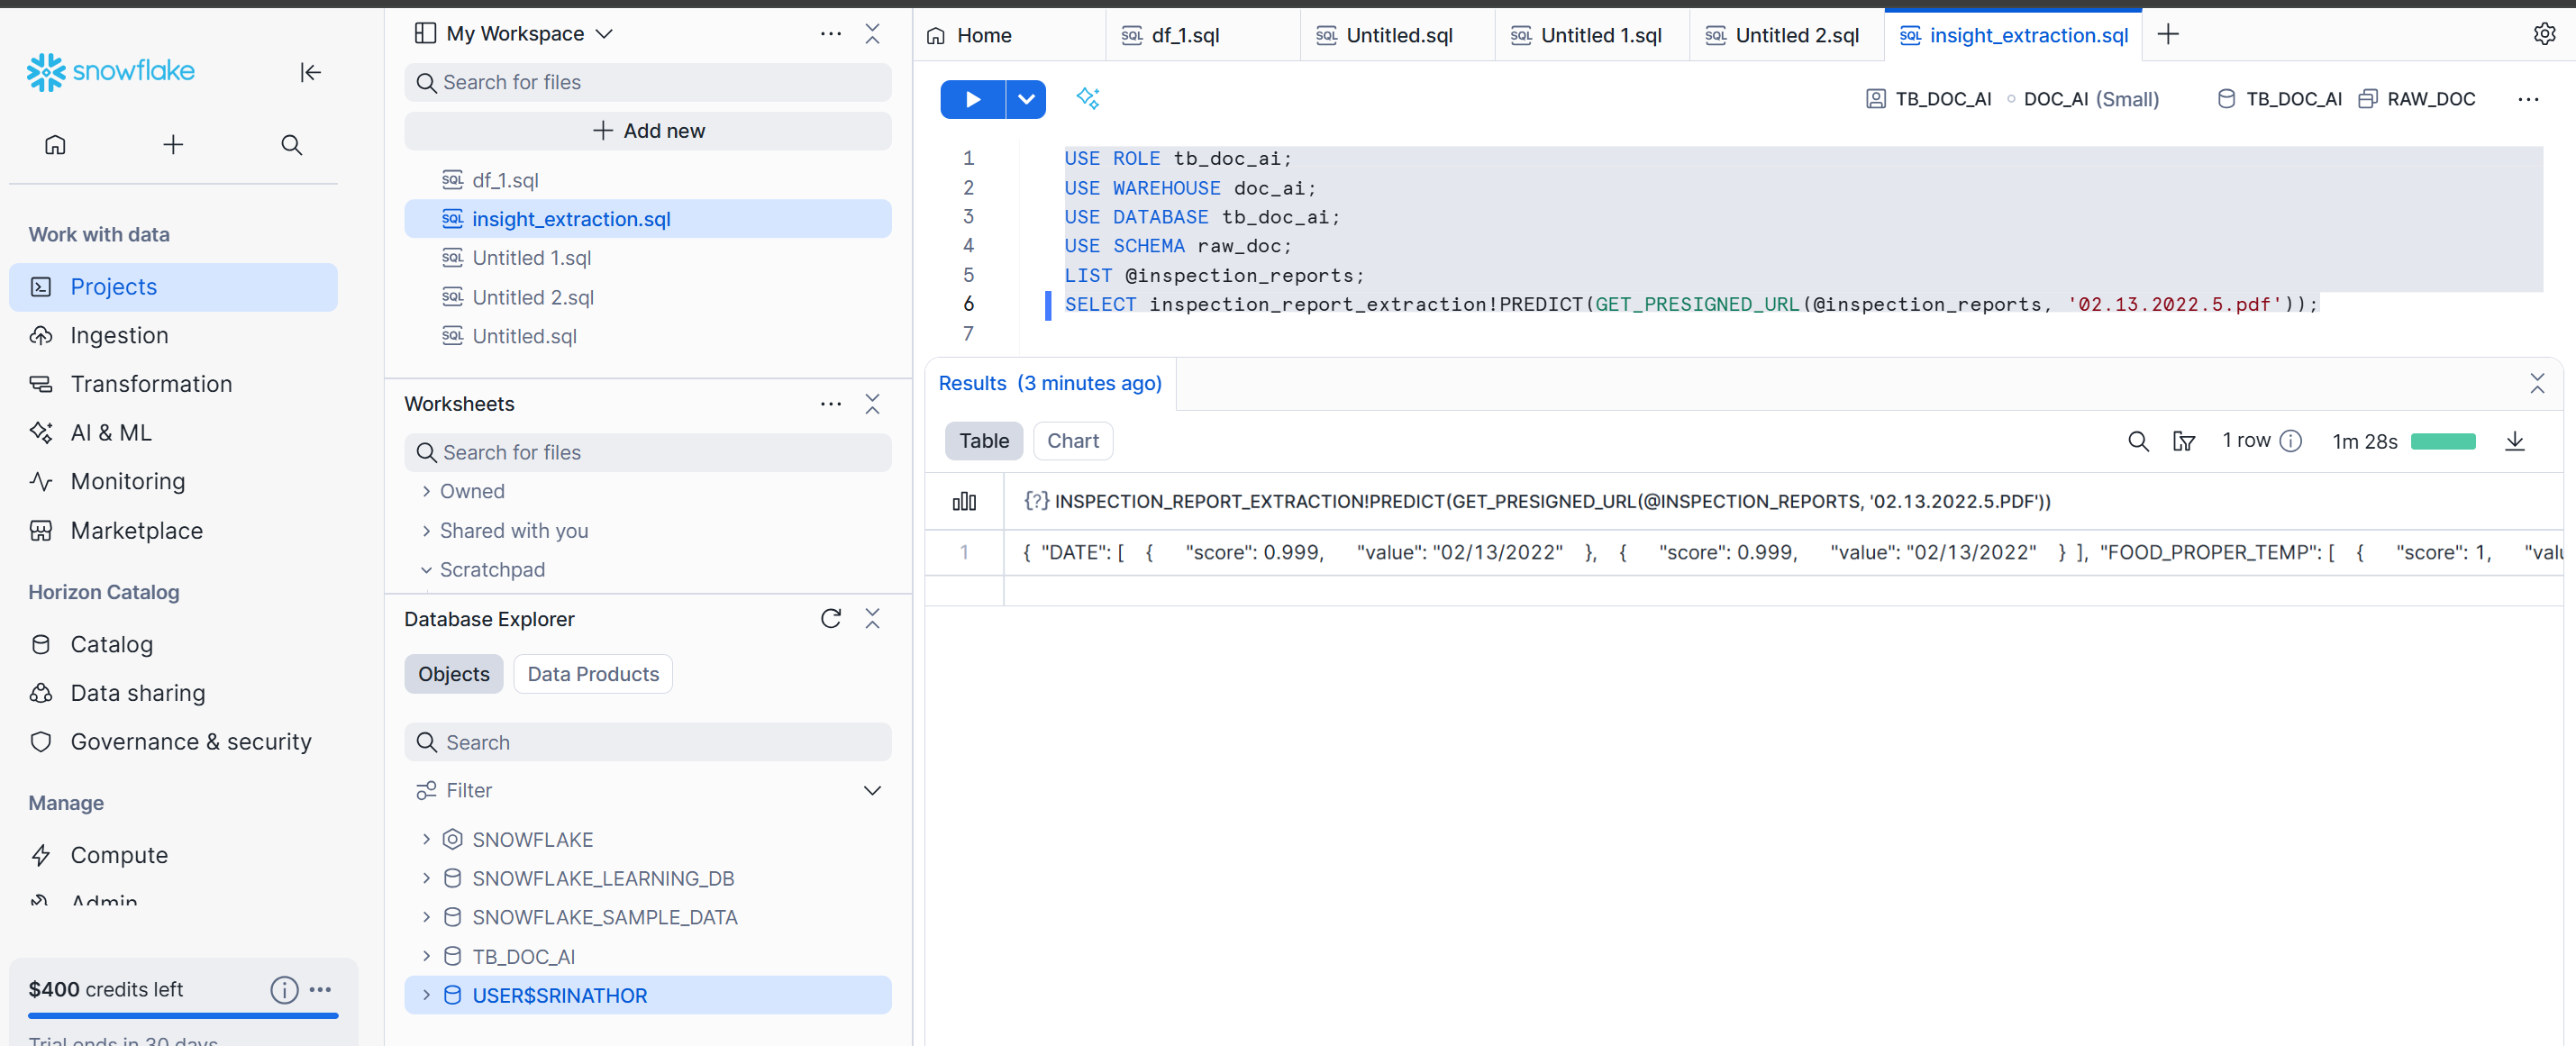


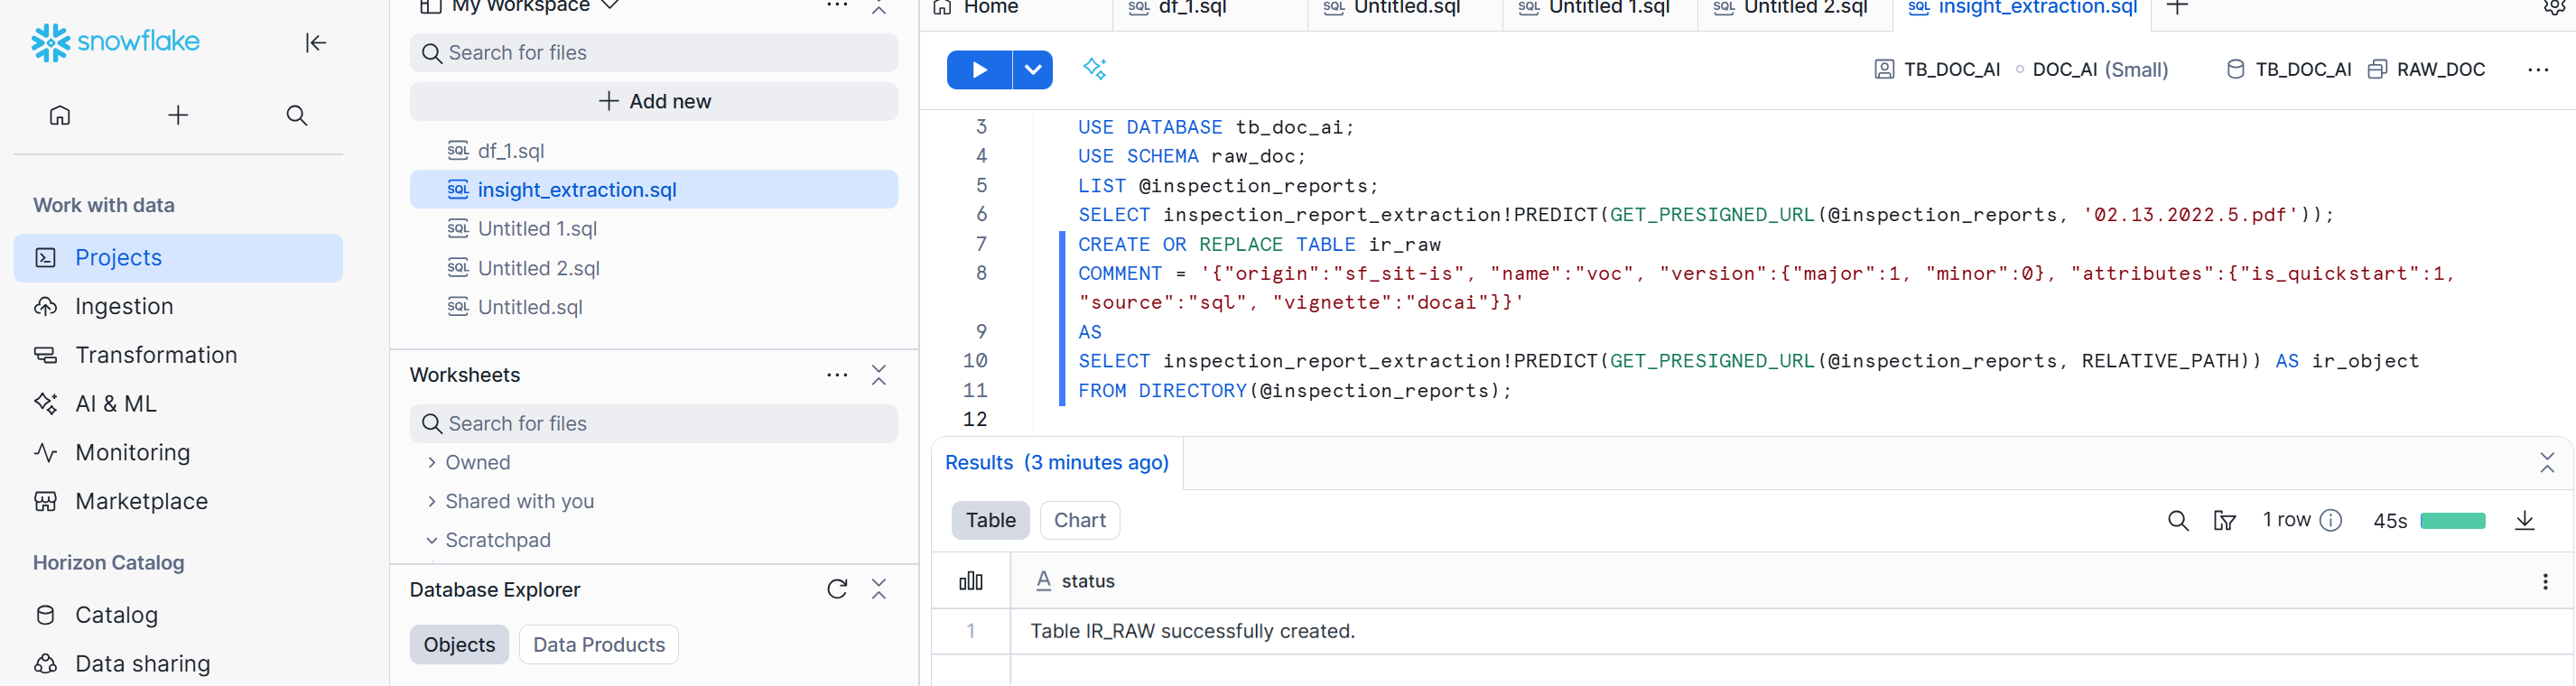

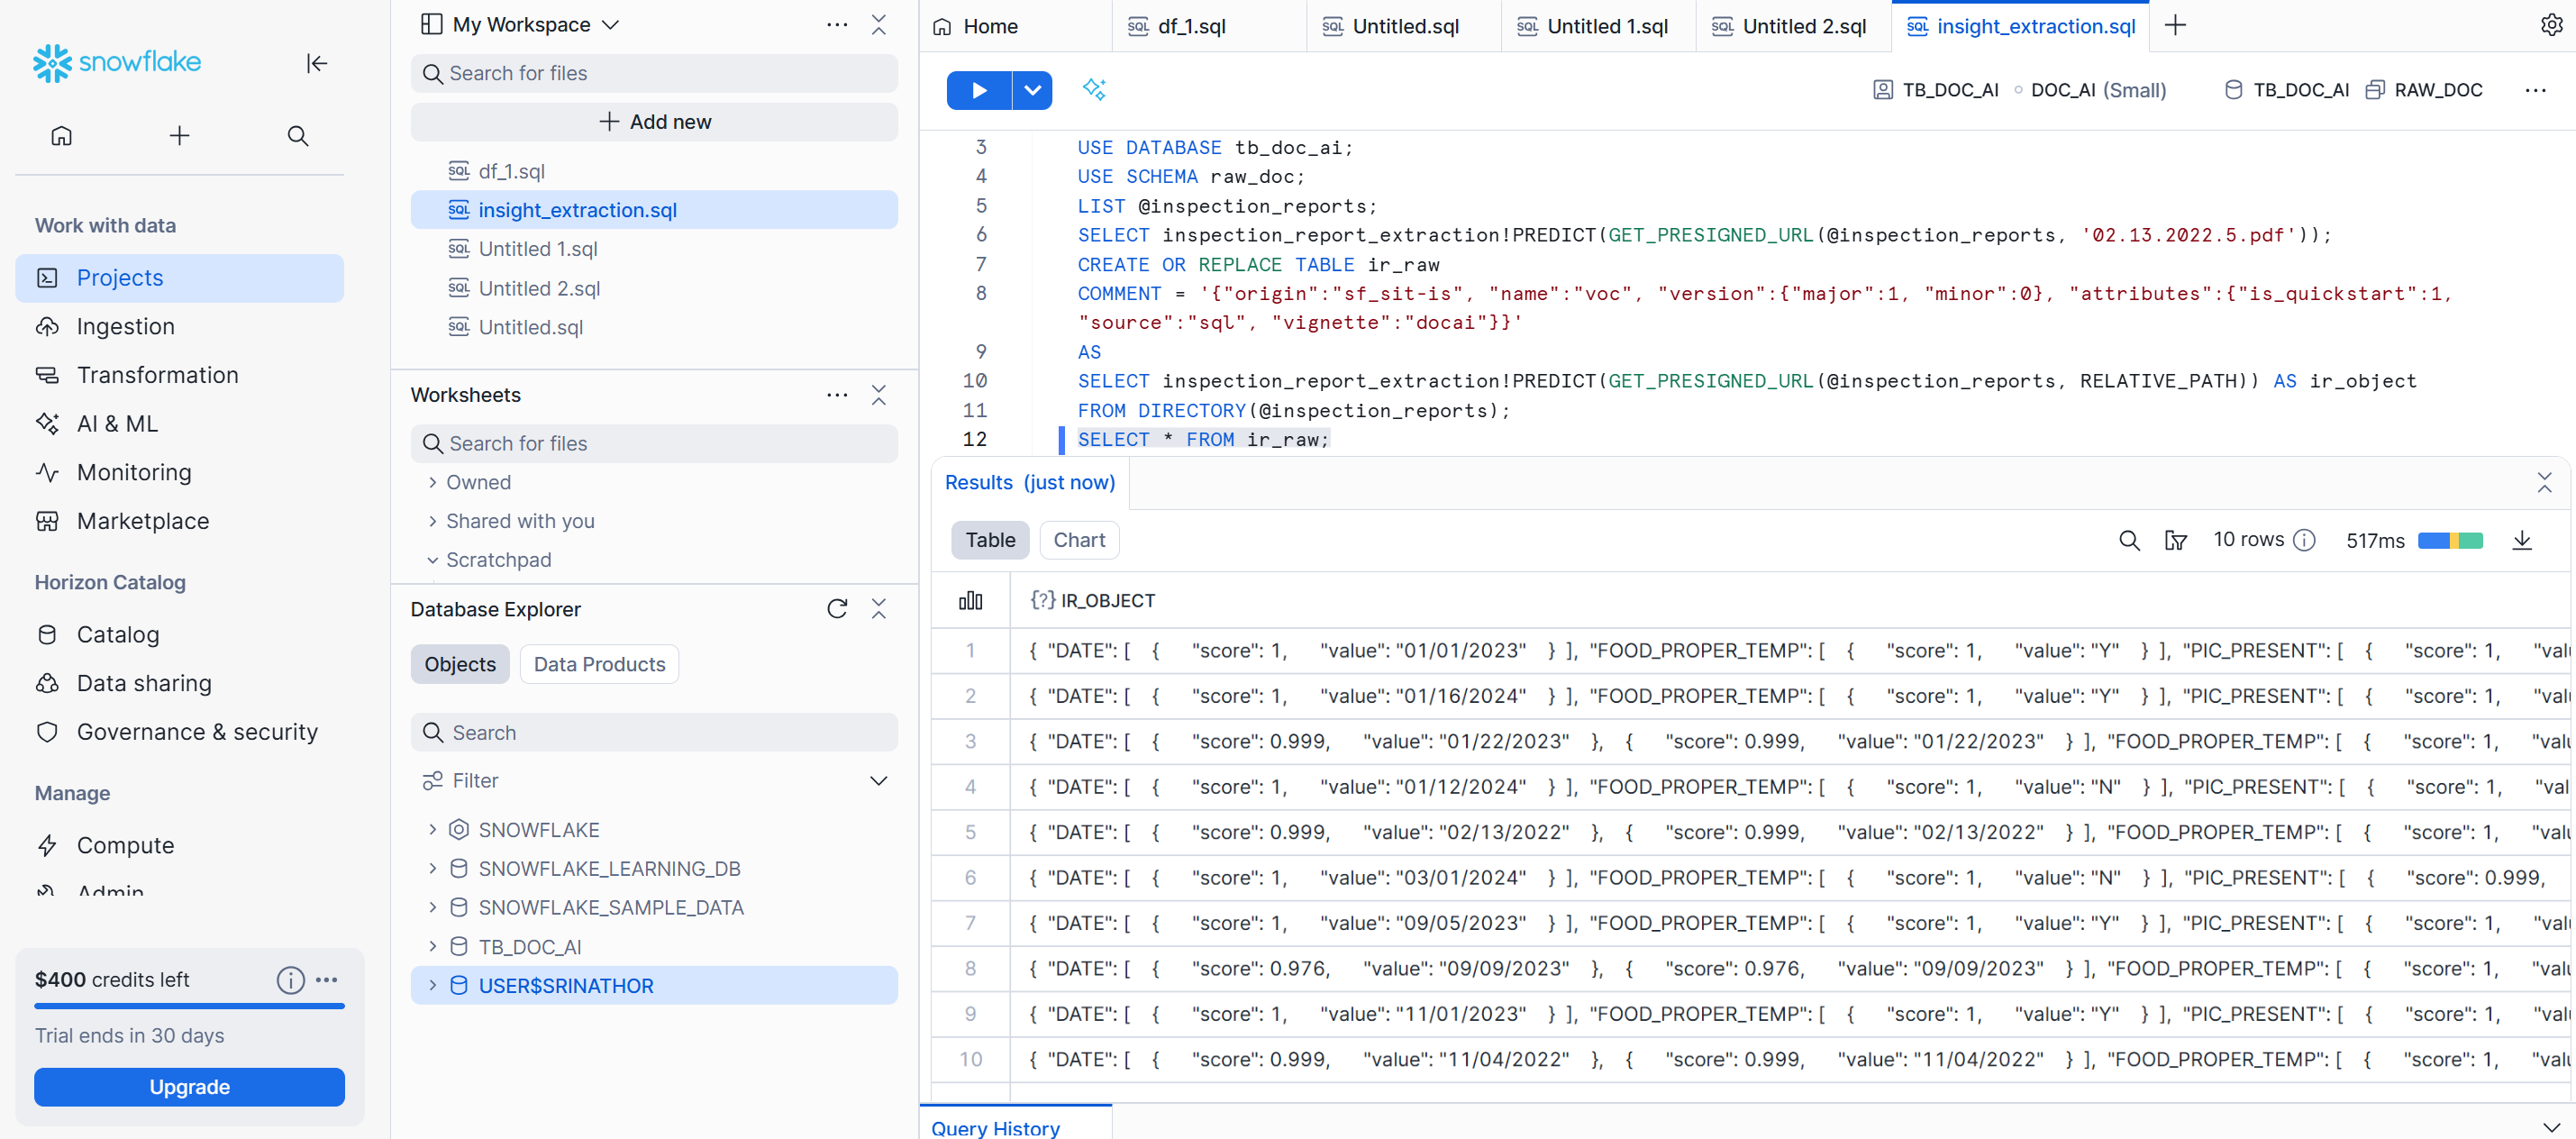

###5. Flattening our Extracted Object
Everything that was extracted for each document is present in the ir_object column. To make analysis easier, let's complete the Quickstart by using Snowflake's Semi-Structured Data Support to show how we can extract columns from our object.

In production, a Data Engineer would typically flatten and promote this data downstream through our Medallion Architecture using objects like Dynamic Tables or Views.

Please execute the next query in which we will use Dot Notation to: - Extract and normalize Date to a consistent format - Extract TRUCK_ID - Extract PIC_PRESENT and FOOD_PROPER_TEMP and convert Y to Pass, N to Fail and X to Not Observed

In [ ]:
SELECT
    TO_DATE(REPLACE(ir_object:"DATE"[0].value::varchar,'-','/')) AS date,
    ir_object:"TRUCK_ID"[0].value::varchar AS truck_id,
    CASE
        WHEN ir_object:"PIC_PRESENT"[0].value::varchar = 'Y' THEN 'Pass' -- convert Y to Pass
        WHEN ir_object:"PIC_PRESENT"[0].value::varchar = 'N' THEN 'Fail' -- convert N to Fail
        WHEN ir_object:"PIC_PRESENT"[0].value::varchar = 'X' THEN 'Not Observed' -- convert X to Not Observed
        ELSE 'Not Observed'
    END AS person_in_charge_present,
    CASE
        WHEN ir_object:"FOOD_PROPER_TEMP"[0].value::varchar = 'Y' THEN 'Pass' -- convert Y to Pass
        WHEN ir_object:"FOOD_PROPER_TEMP"[0].value::varchar = 'N' THEN 'Fail' -- convert N to Fail
        WHEN ir_object:"FOOD_PROPER_TEMP"[0].value::varchar = 'X' THEN 'Not Observed' -- convert X to Not Observed
        ELSE 'Not Observed'
    END AS food_proper_temp
FROM ir_raw
ORDER BY truck_id;

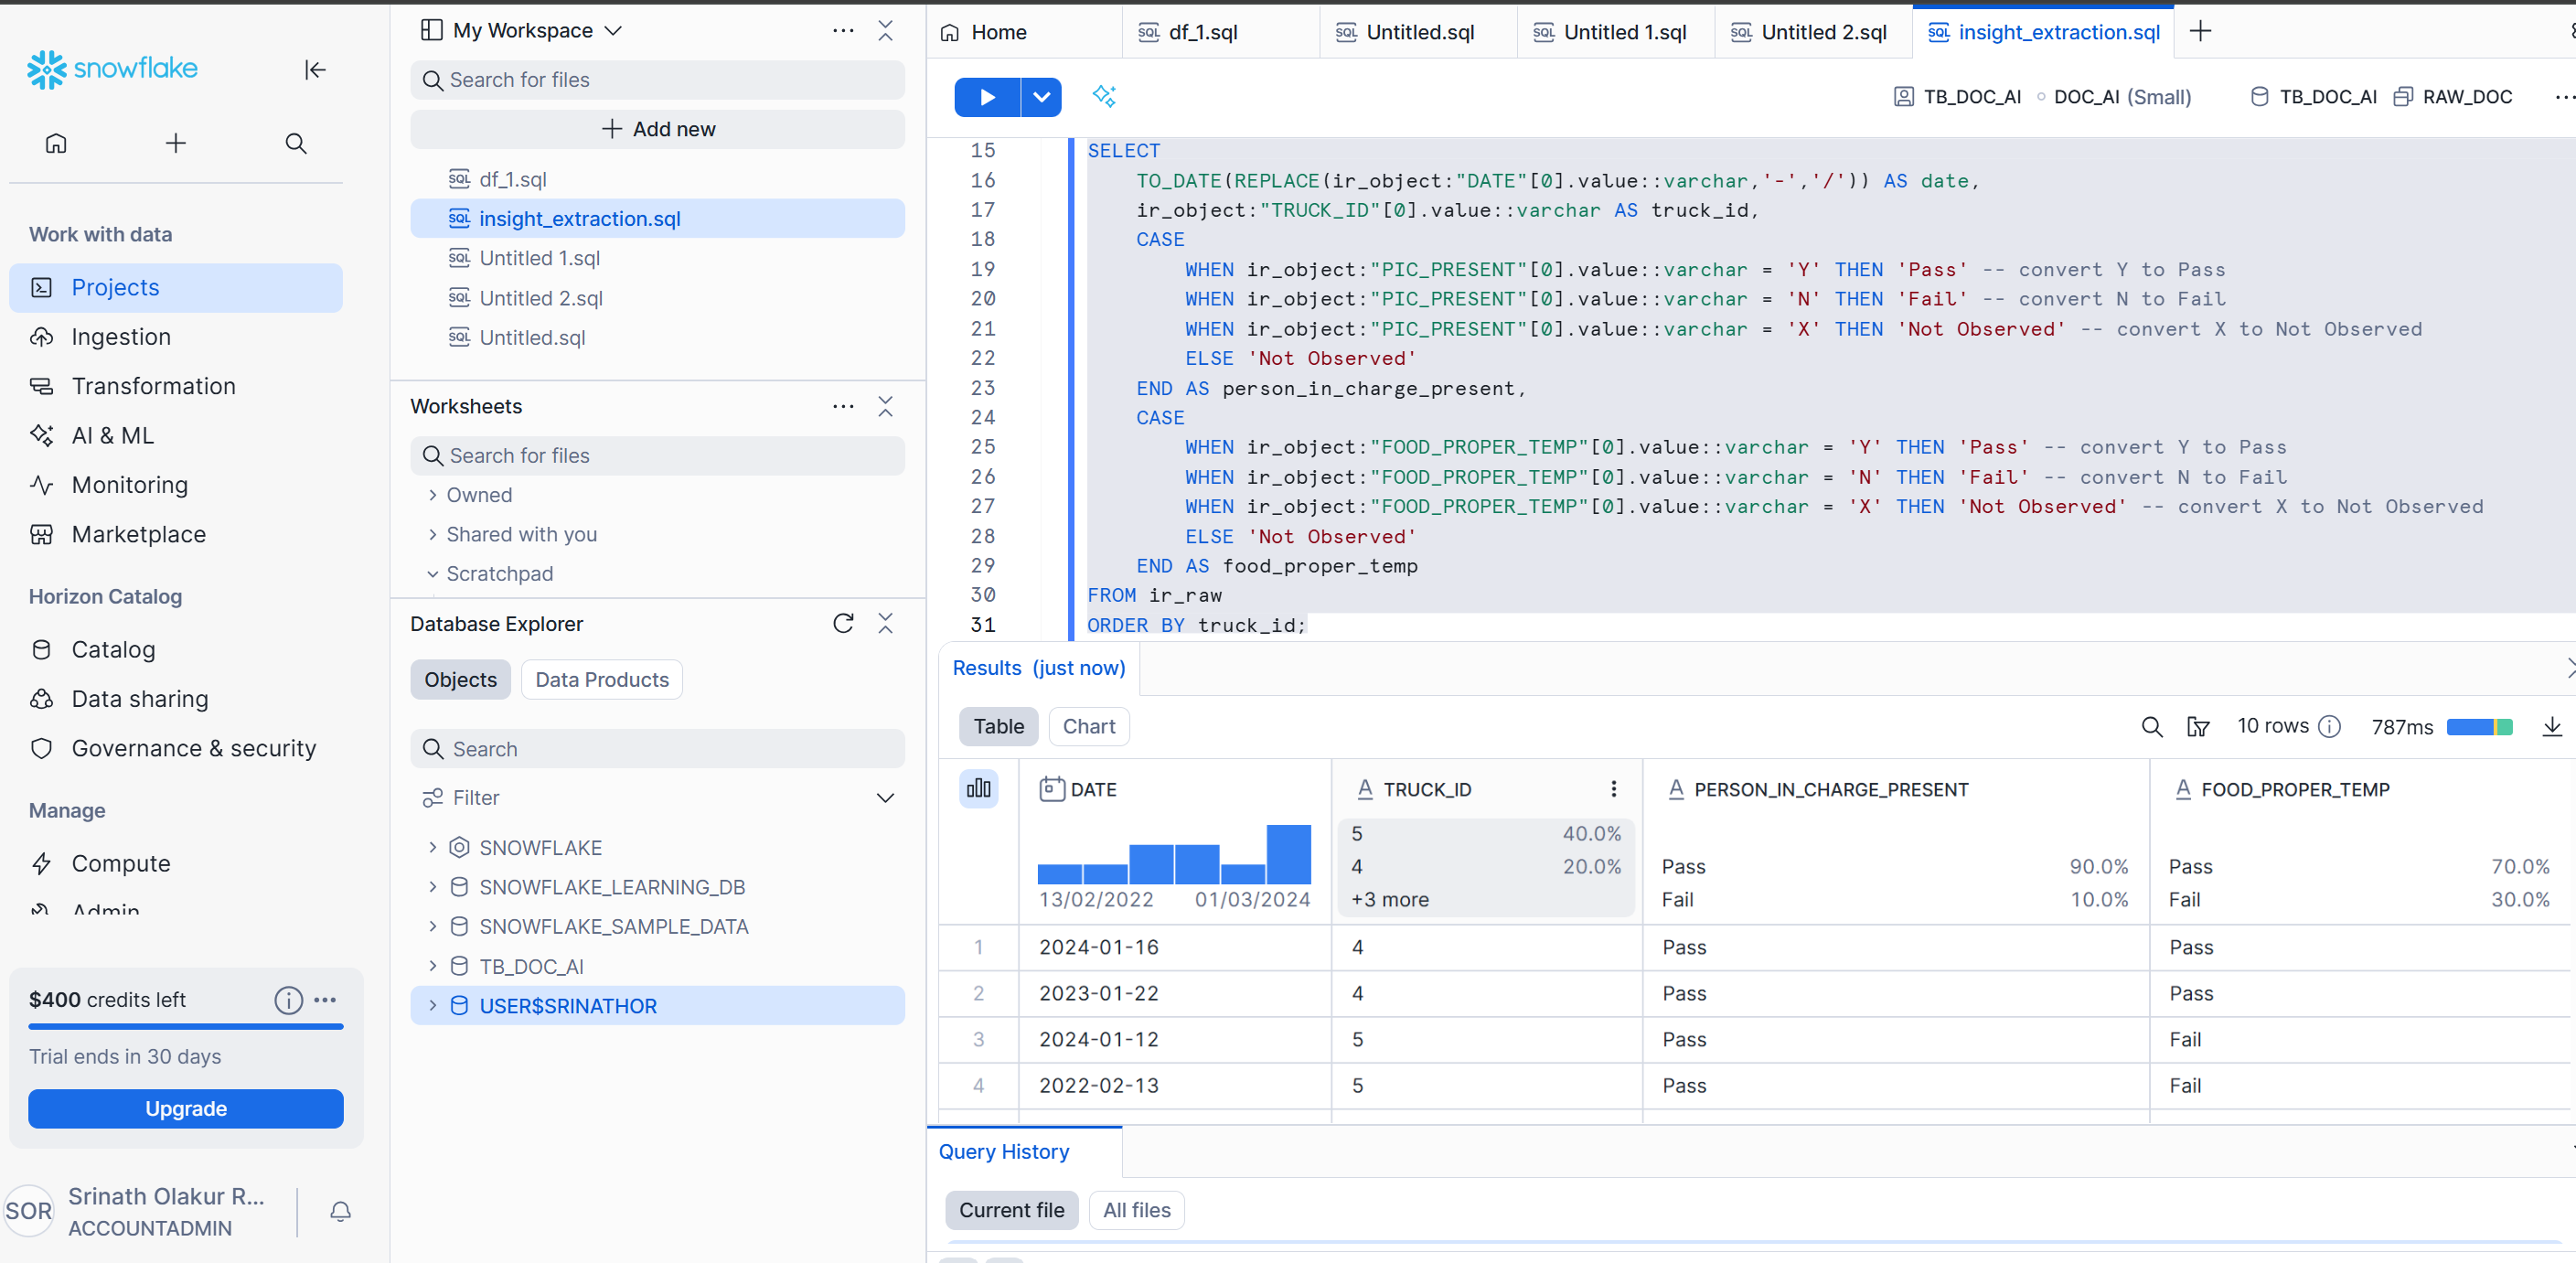

### 6. Conclusion
Extracting Insights with SnowFlake Document AI process of moving unstructred PDF to tabular result.